# DSCI Group Project Proposal - Pulsar Stars

_Group 66 (Andrew Ahn, Calvin Choi, Allan Hu, Dishika Taneja_)

Pulsar stars are rapidly rotating neutron stars that emit electromagnetic waves from its poles. As it spins, the "beam" of electromagnetic waves sweeps across Earth in the form of radio waves.

These stars can be measured and found based on the radio waves that they release, but since many radio signals received by our measuring devices are caused by interference or noise and there are so many of them, it is very time consuming to determine whether a signal is a pulsar star or not. In this project, we will make a model that predicts whether a radio observation is a pulsar star.

To do this, we will use the HTRU2 data set from the UC Irving Machine Learning Repository. This dataset features 1,639 actual pulsar star observations and 16,259 observations of noise. The measured data for each observation includes mean, standard deviation, excess kurtosis, and skew for both the pulse profile and the DM-SNR curve of the signal.

### Introduction ###

### Abstract (Preliminary exploratory data analysis)

In [1]:
library(tidyverse)
library(tidymodels)
library(GGally)
install.packages("groupdata2")
library(groupdata2)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

#### Table 1: The data with column labels and a factored class.

The last column shows the class, where 1 indicates a pulsar star and 0 indicates noise or interference.

In [2]:
signals <- read_csv("data/HTRU_2.csv", col_names = FALSE) |>
    rename(profile_mean = X1, profile_std = X2, profile_exk = X3, profile_skew = X4,
                       curve_mean = X5, curve_std = X6, curve_exk = X7, curve_skew = X8, class = X9)
signals_set <- signals |>
    mutate(class = as_factor(class))
signals_set

Rows: 17898 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): X1, X2, X3, X4, X5, X6, X7, X8, X9

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


profile_mean,profile_std,profile_exk,profile_skew,curve_mean,curve_std,curve_exk,curve_skew,class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
140.5625,55.68378,-0.2345714,-0.6996484,3.199833,19.11043,7.975532,74.24222,0
102.5078,58.88243,0.4653182,-0.5150879,1.677258,14.86015,10.576487,127.39358,0
103.0156,39.34165,0.3233284,1.0511644,3.121237,21.74467,7.735822,63.17191,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
119.3359,59.93594,0.1593631,-0.74302540,21.430602,58.87200,2.499517,4.595173,0
114.5078,53.90240,0.2011614,-0.02478884,1.946488,13.38173,10.007967,134.238910,0
57.0625,85.79734,1.4063910,0.08951971,188.306020,64.71256,-1.597527,1.429475,0


#### Table 2: The training data set.
75% of the data is training and 25% testing.

In [3]:
set.seed(2022)
signals_split <- initial_split(signals_set, prop = 0.75, strata = class)
signals_training <- training(signals_split)
signals_testing <- testing(signals_split)
signals_training

profile_mean,profile_std,profile_exk,profile_skew,curve_mean,curve_std,curve_exk,curve_skew,class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
140.5625,55.68378,-0.2345714,-0.6996484,3.199833,19.11043,7.975532,74.24222,0
102.5078,58.88243,0.4653182,-0.5150879,1.677258,14.86015,10.576487,127.39358,0
103.0156,39.34165,0.3233284,1.0511644,3.121237,21.74467,7.735822,63.17191,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
119.3359,59.93594,0.1593631,-0.74302540,21.430602,58.87200,2.499517,4.595173,0
114.5078,53.90240,0.2011614,-0.02478884,1.946488,13.38173,10.007967,134.238910,0
57.0625,85.79734,1.4063910,0.08951971,188.306020,64.71256,-1.597527,1.429475,0


#### Table 3: The averages of all possible predictors.
To determine whether standardization is needed. Since the values are quite far apart in scale, the data should be scaled and centered before use in a model.

In [4]:
signals_means <- signals_training |>
    select(!class) |>
    map_df(mean)
signals_means #Can be used to decide if normalization is needed.

profile_mean,profile_std,profile_exk,profile_skew,curve_mean,curve_std,curve_exk,curve_skew
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
110.9522,46.53494,0.4830235,1.783967,12.79356,26.43195,8.287479,104.7102


#### Table 4: The sum of each class.
To determine whether the data must be scaled and centered. Since there are many more results for noise than pulsars, the data should be balanced.

In [5]:
signals_class <- signals_training |>
    group_by(class) |>
    summarize(n = n())
signals_class #Shows how many pulsars there are and how many noise signals there are in the training set.

class,n
<fct>,<int>
0,12168
1,1255


### Plot 1: GGPairs analysis
To find the best variables, we can analyse the variables in pairs and see which two variables best separate pulsar stars from noise radio signals.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



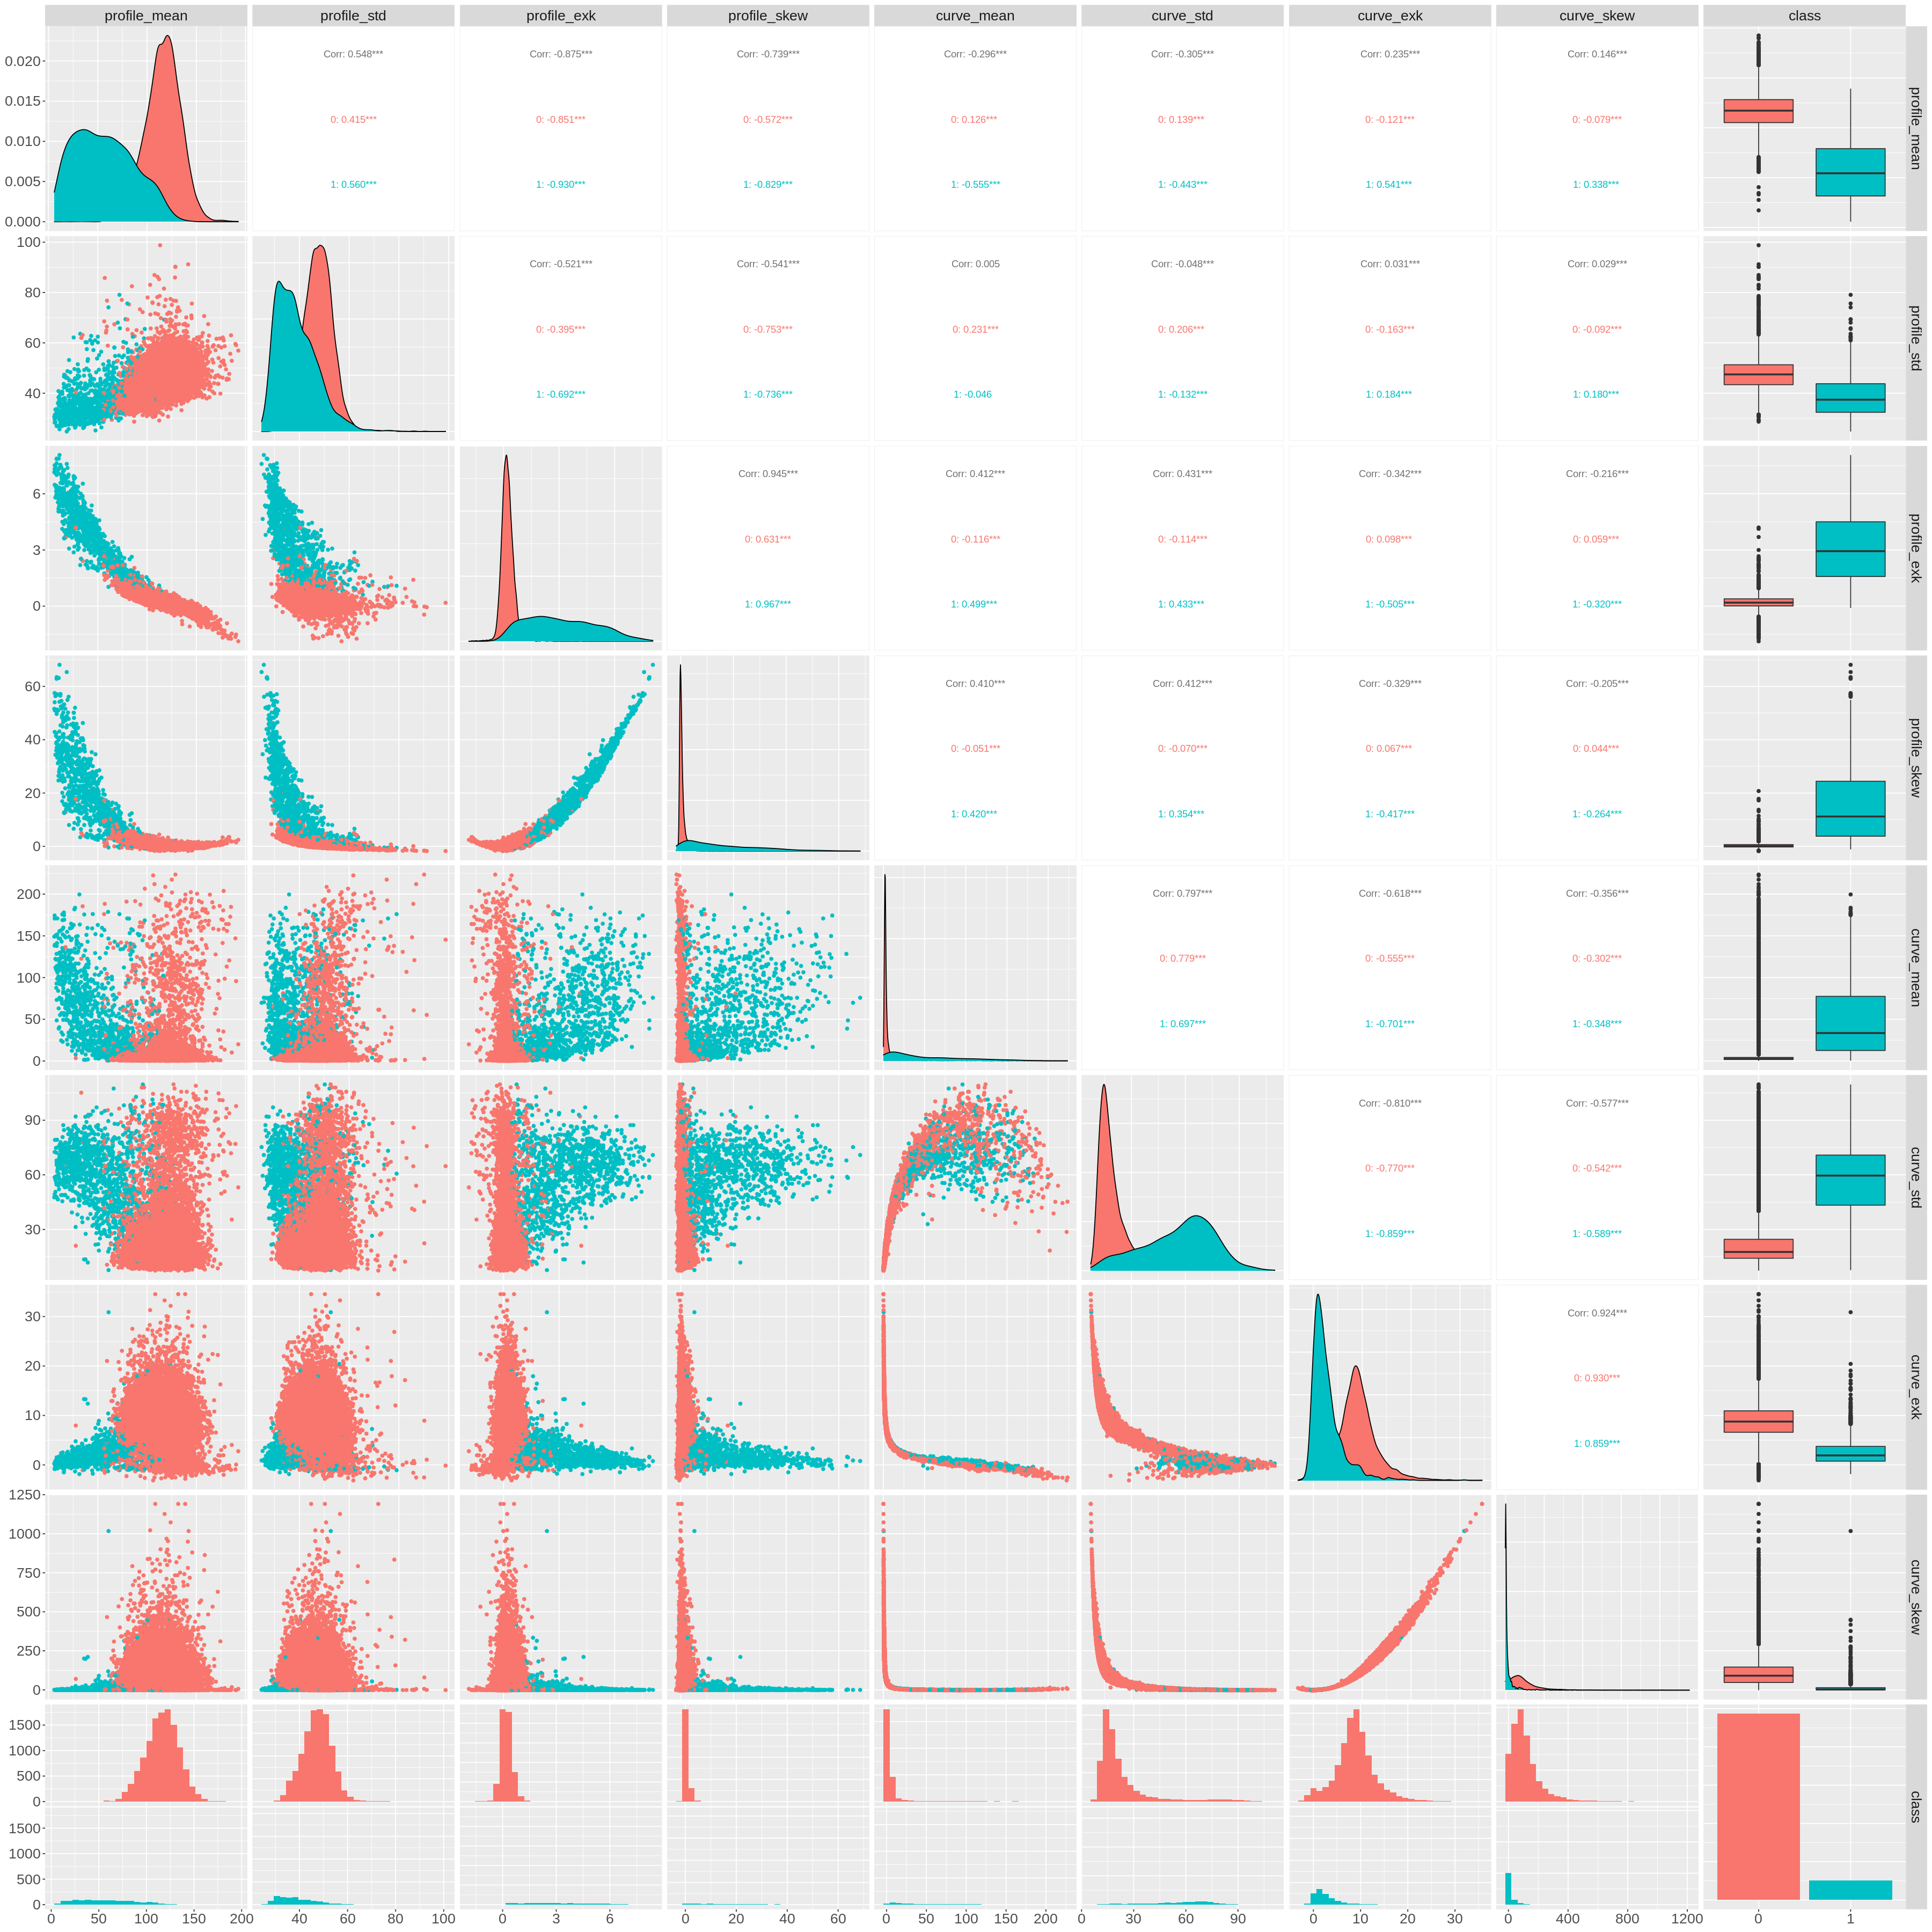

In [6]:
analysis_plot <- signals_training |>
                #select(!profile_mean:profile_skew) |>
                ggpairs(aes(color = class)) +
                theme(text = element_text(size = 20))

options(repr.plot.width = 30, repr.plot.height = 30) 
analysis_plot

Looking at the pairs here, it seems like the profile variables sepearate pulsars and non-pulsars more cleanly. 
So we have isolated them in the ggpairs below for closer examination:
### Plot 2: GGPairs analysis (Profile only)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



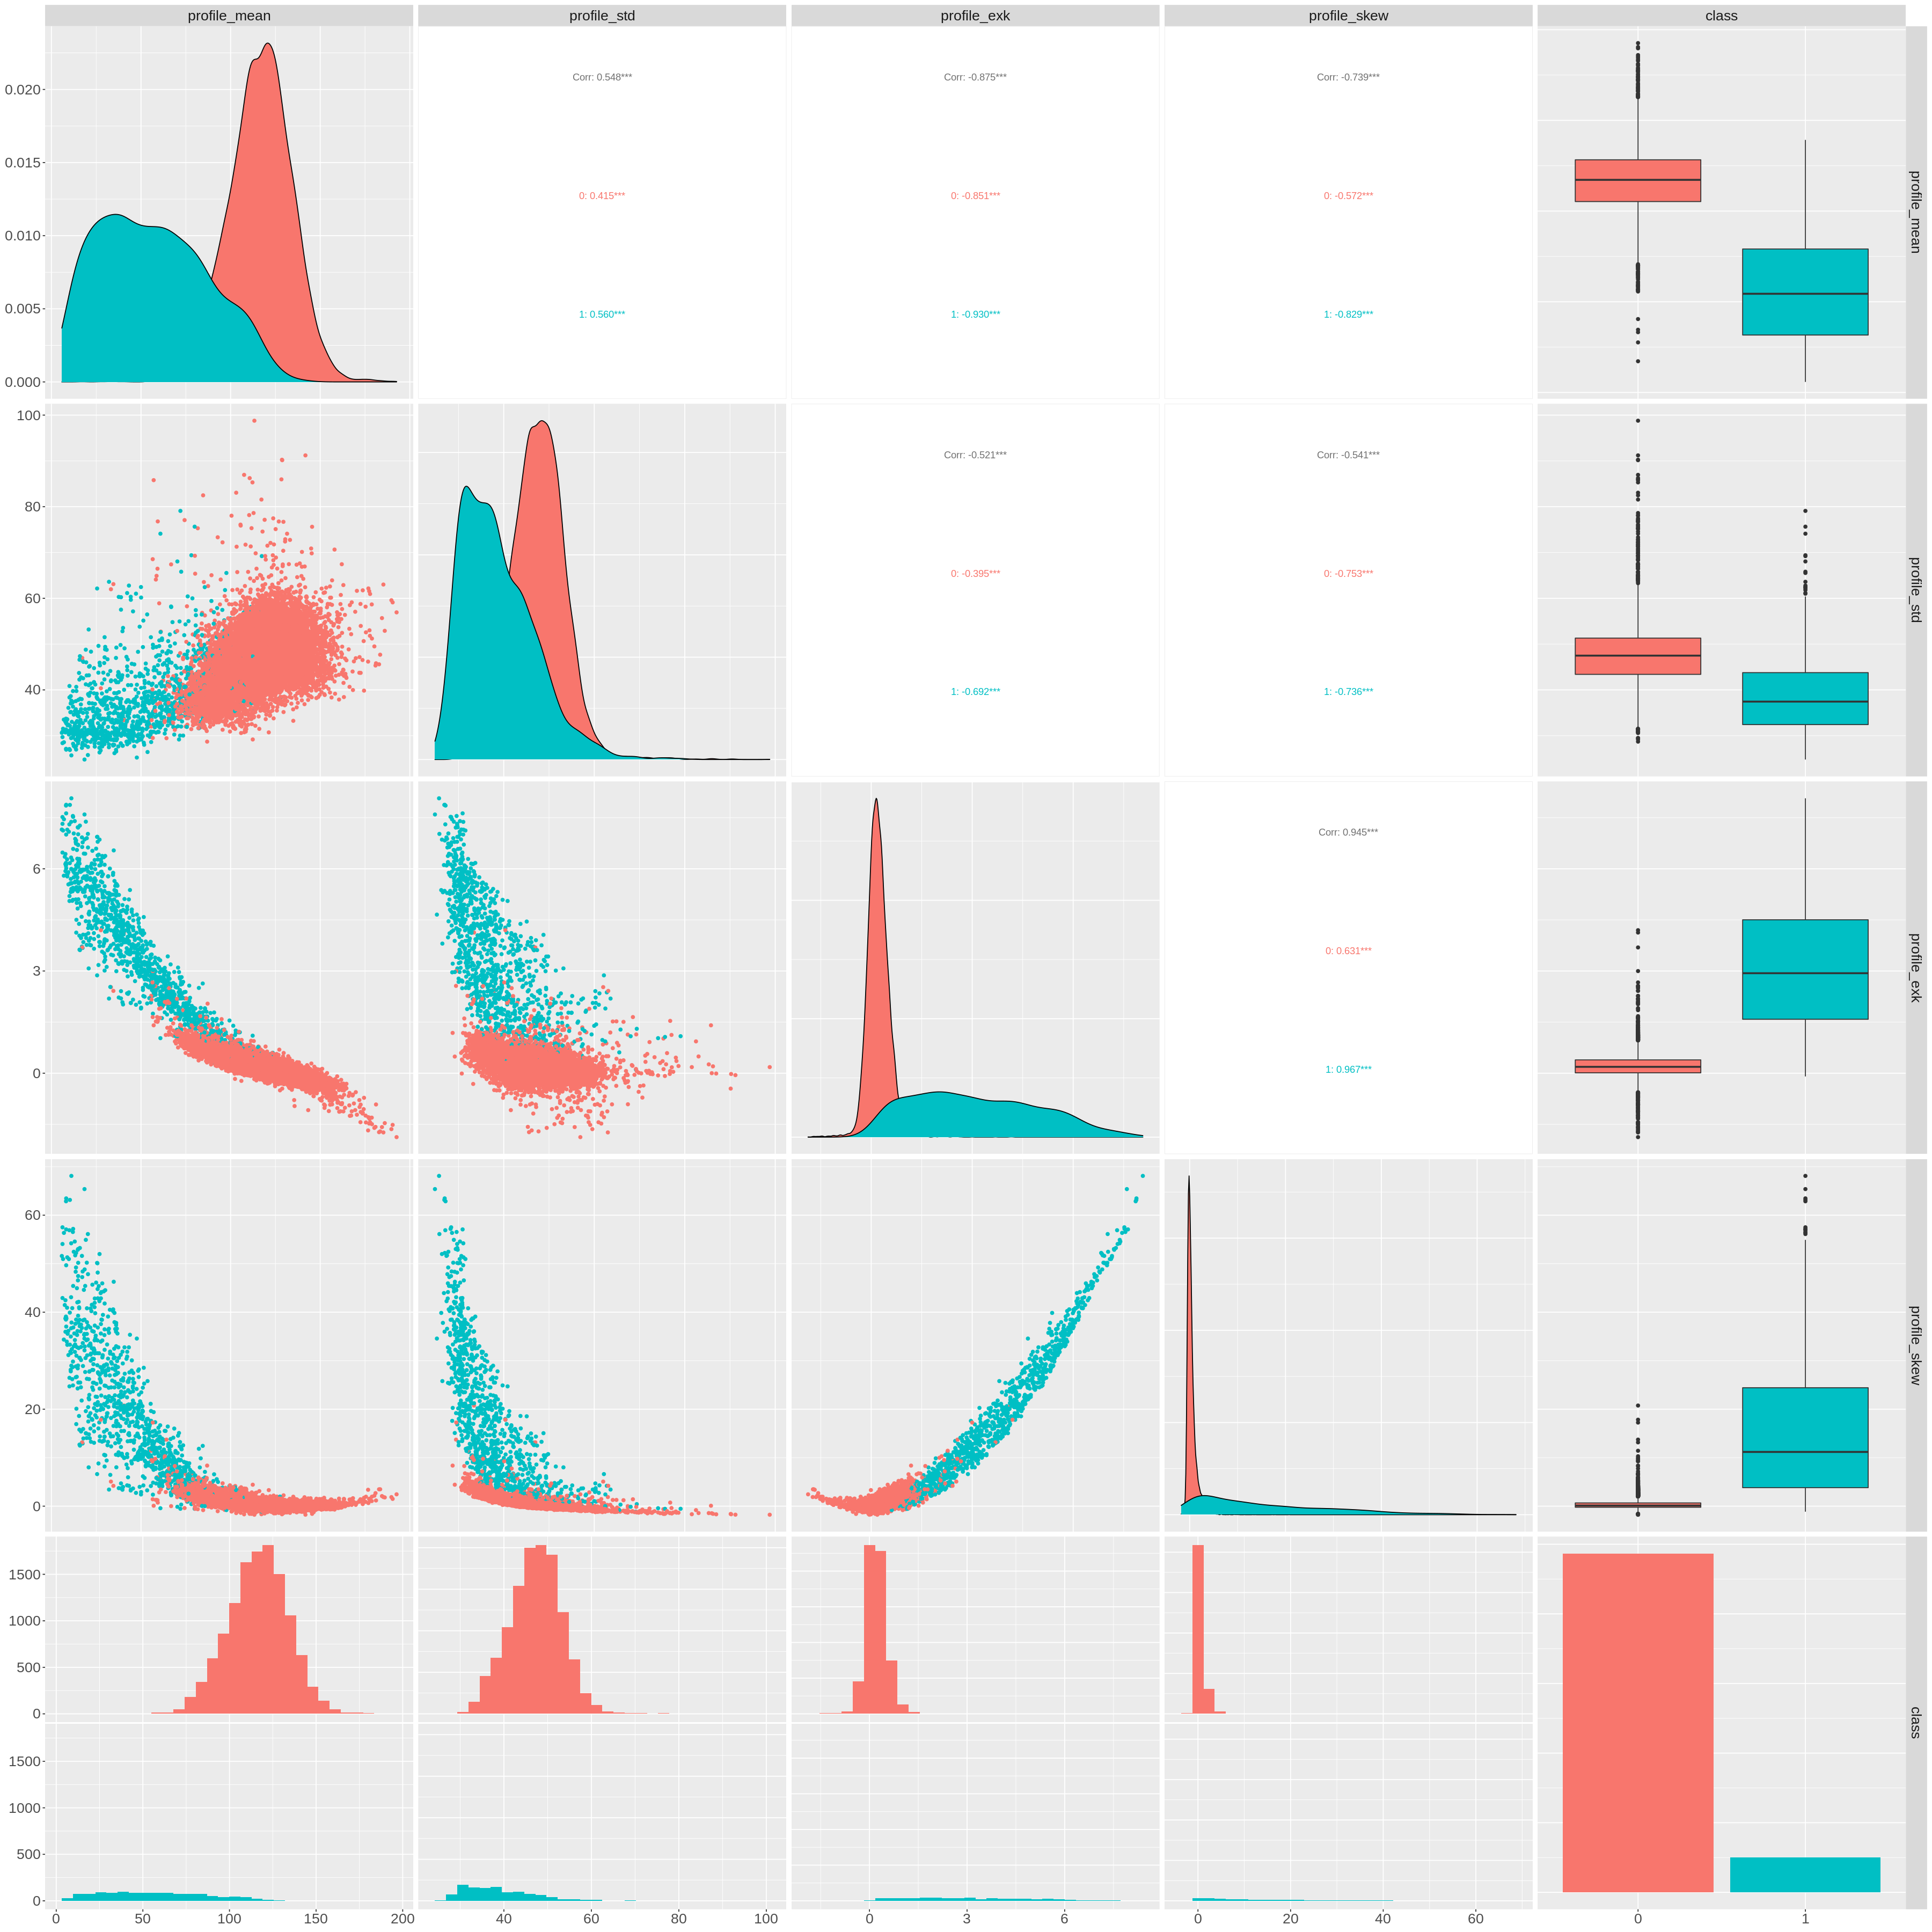

In [7]:
analysis_plot_profile <- signals_training |>
                select(!curve_mean:curve_skew) |>
                ggpairs(aes(color = class)) +
                theme(text = element_text(size = 20))
options(repr.plot.width = 30, repr.plot.height = 30) 
analysis_plot_profile

### Plot 3: Close-up of Profile Skew vs Profile EXK
This plot gives an example so that you can see how the pulars and non-pulsars are seperated when judging by these variables.

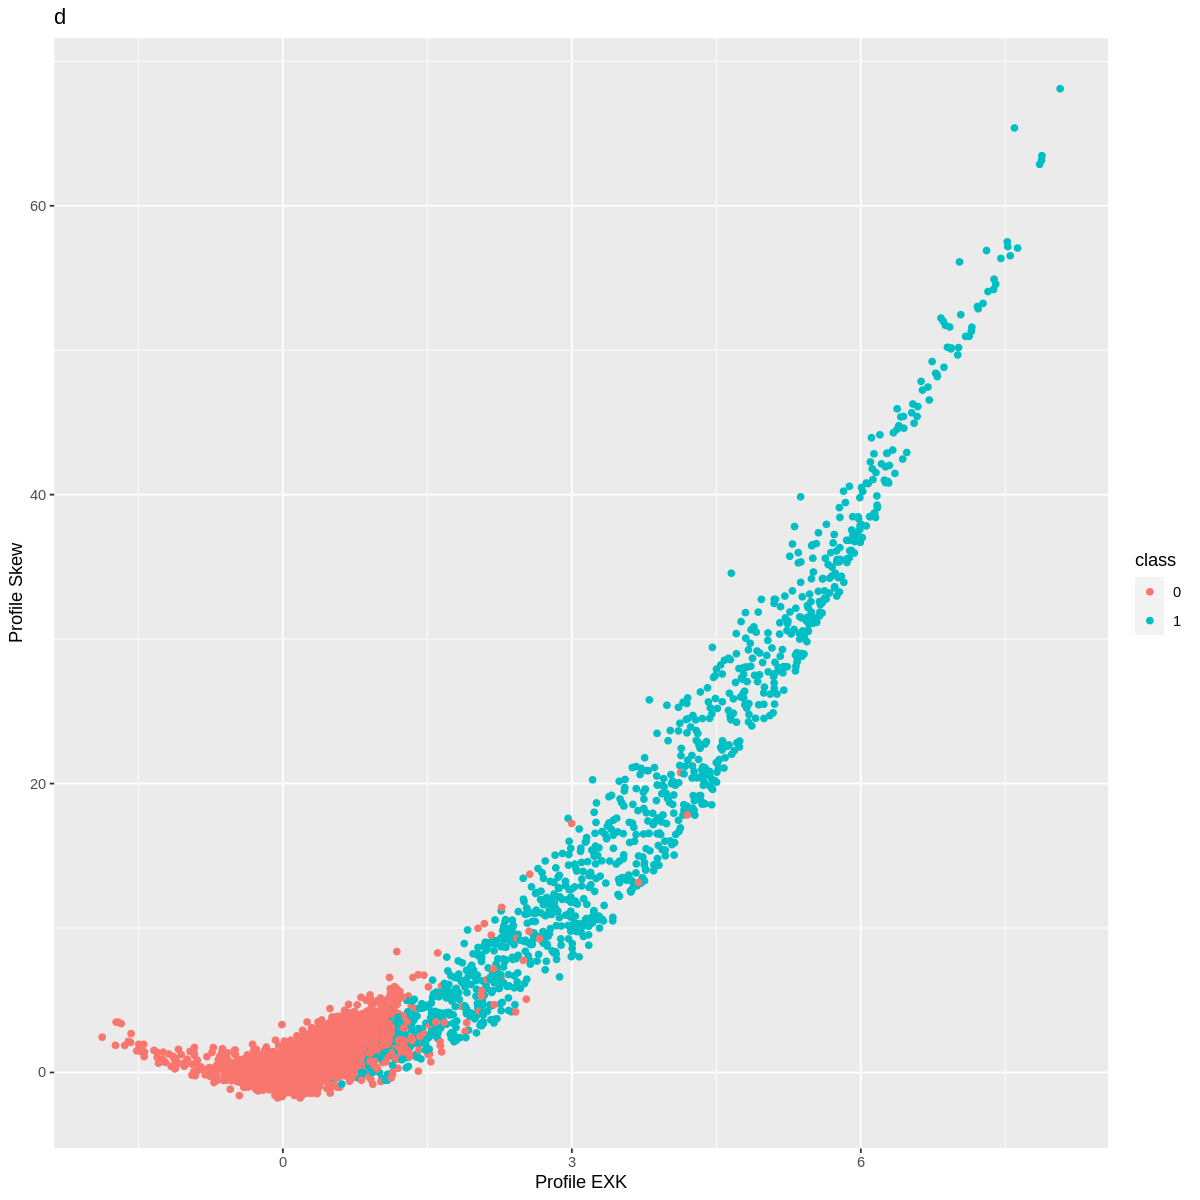

In [10]:
peks_pskew_plot <- signals_training |>
                    ggplot(aes(x=profile_exk, y=profile_skew, color = class)) + 
                    geom_point() + 
                    xlab("Profile EXK") +
                    ylab("Profile Skew")
options(repr.plot.width = 10, repr.plot.height = 10) #readjusts plot size 

peks_pskew_plot

### Methods

For the data analysis, we will perform classification using the variables profile_mean, profile_std, profile_exk and profile_skew. The curve variables will be omitted for the classification as the pairs analysis demonstrated that the curve_mean, curve_std, curve_exk and the curve_skew render visualizations that do not separate the pulsar star points and the non-pulsar star points clearly.

For the classification, we will use the K-nearest neighbors algorithm in R to code a classifier that will determine whether a given observation classifies as a pulsar star or not. We will first preprocess the data by creating a recipe for the model, then train our classifier by defining a model specification using the K-nearest neighbors function in R, fit the specification onto our dataset using the fit function, then combine everything together using the workflow function. We will then apply cross validation onto our training data to determine the value of K that will render the greatest accuracy, then test the model using that K value with our testing dataset to determine whether our model is satisfactory.

We will visualize the results by creating a scatterplot with profile_exk plotted on the x-axis and profile_skew plotted on the y-axis, then demonstrate with observations in our testing dataset whether our model does a good job of classifying the observations onto the plot. 

### Analysis

In [11]:
#Data Preprocessing
#Manually upsample using the groupdata2 package
signals_upsampled <- signals_training |>
                        upsample(cat_col = "class")
#Recipe using profile. Scaling and Centering.
signals_recipe <- recipe(class ~ profile_mean + profile_std + profile_exk + profile_skew, data = signals_upsampled) |>
                    step_scale(all_predictors()) |>
                    step_center(all_predictors())

#Creating a model for tuning.
knn_model_tuning <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")
#Five fold vfold
signals_vfold <- vfold_cv(signals_training, v = 5, strata = class)
#Testing K values from 1 to 25 for every 4 k values
k_vals <- tibble(neighbors = seq(1,25,4))
#WARNING, TAKES A LONG TIME TO RUN
knn_tune <- workflow() |>
    add_recipe(signals_recipe) |>
    add_model(knn_model_tuning) |>
    tune_grid(resamples = signals_vfold, grid = k_vals) |>
    collect_metrics()
knn_tune

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.9650599,5,0.0006171120,Preprocessor1_Model1
1,roc_auc,binary,0.8958960,5,0.0054672538,Preprocessor1_Model1
5,accuracy,binary,0.9779481,5,0.0007949266,Preprocessor1_Model2
⋮,⋮,⋮,⋮,⋮,⋮,⋮
21,roc_auc,binary,0.9549609,5,0.0044107348,Preprocessor1_Model6
25,accuracy,binary,0.9785442,5,0.0009099548,Preprocessor1_Model7
25,roc_auc,binary,0.9561942,5,0.0038466820,Preprocessor1_Model7


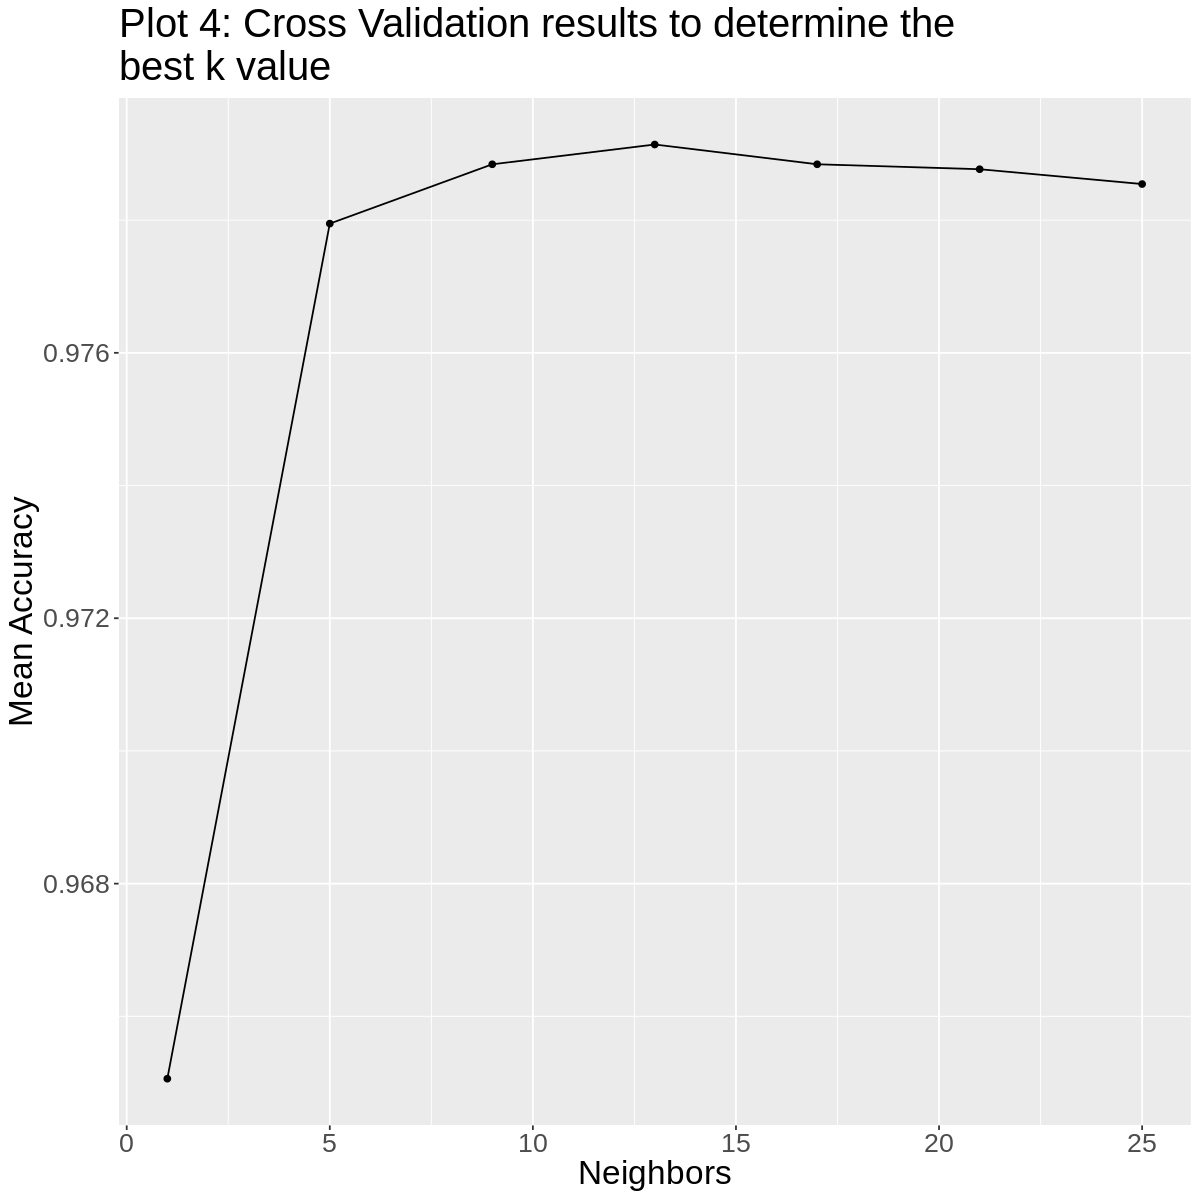

In [15]:
accuracies <- knn_tune |>
                filter(.metric == "accuracy") |>
                select(neighbors, mean)
cross_val_plot <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
    geom_line() +
    geom_point() +
    labs(x = "Neighbors", y = "Mean Accuracy", title = "Plot 4: Cross Validation results to determine the 
best k value") +
    theme(text = element_text(size = 20))
cross_val_plot

The peak at around 12 neighbors is unstable as it seems to fluctuate a bit, so 20 neighbors will be used instead. Furthermore, cross validation was performed up to 100 for every 10 k values, and accuracy only decreased from around k = 9 onwards, so it is unlikely that there is a higher accuracy at k values greater than what can be seen in this graph.

In [13]:
#final model
knn_model_tuning <- nearest_neighbor(weight_func = "rectangular", neighbors = 20) |>
    set_engine("kknn") |>
    set_mode("classification")
signals_fit <- workflow() |>
    add_recipe(signals_recipe) |>
    add_model(knn_model_tuning) |>
    fit(data = signals_upsampled)
signals_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(20,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.06019888
Best kernel: rectangular
Best k: 20

### Table 5: Testing set with predictions
The following three tables are for use in the discussion.

In [17]:
#testing set with predictions
signal_predictions <- predict(signals_fit, signals_testing)|>
    bind_cols(signals_testing)
signal_predictions

.pred_class,profile_mean,profile_std,profile_exk,profile_skew,curve_mean,curve_std,curve_exk,curve_skew,class
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0,130.3828,39.84406,-0.1583228,0.3895404,1.220736,14.37894,13.539456,198.23646,0
0,114.3672,51.94572,-0.0944989,-0.2879841,2.738294,17.19189,9.050612,96.61190,0
1,100.8906,51.89039,0.6274865,-0.0264978,3.883779,23.04527,6.953168,52.27944,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
0,130.5000,46.14955,0.084445004,-0.1073548,1.5292642,11.75709,12.533831,211.327081,0
0,127.0703,47.66356,0.006552426,-0.1236337,0.8536789,11.19721,16.122702,296.507738,0
0,122.5547,49.48561,0.127978091,0.3230609,16.4096990,44.62689,2.945244,8.297092,0


### Table 6: Accuracy of predictions on testing set

In [18]:
#metrics on testing set (accuracy)
signal_metrics <- signal_predictions |>
    metrics(truth = class, estimate = .pred_class)
signal_metrics

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9343017
kap,binary,0.6662989


### Table 7: Confusion Matrix on testing set

In [20]:
#confusion matrix on testing set
signal_conf_mat <- signal_predictions |>
    conf_mat(truth = class, estimate = .pred_class)
signal_conf_mat

          Truth
Prediction    0    1
         0 3836   39
         1  255  345

## Hypothesis (Expected outcomes and significance)

<u> We expect to classify observations as a pulsar or not a pulsar using the profile values as they best reflect a relationship between the two classifications. <u>

Pulsars are being used by scientists to investigate the most extreme forms of matter, look for extrasolar planets, and measure cosmic distances. Pulsars may also aid in the discovery of gravitational waves, which may lead to the detection of powerful cosmic occurrences like the collisions of supermassive black holes. This classification model can help scientists with their research by quickly analysing new observations for pulsar stars that may be useful for their research.

In the future, we may be able to use models similar to this one to classify pulsars more usefully, giving information on which pulsars are especially useful in research due to properties based on its radio signal.
    
    (Should likely be combined with introduction)

### Results and Visualizations

Based on our analysis, we found that our model using the four profile variables, can accurately classify a pulsar star apart from other elements at around a 93% accuracy. We found that best k value was 9 (or 20) as it reflected a good balance with little to no under/overfitting. 

Being able to identify pulsars can be helpful across different functions. Pulsars are most useful for physicists and astronomers who want to study and the nature of gravity as well as the behaviour of matter on a cosmic scale. Pulsar stars unique characteristics such as its consisting 'pulsing' and emission of radio waves give useful information to be studied regarding special relativity (Einstein's golden child theory), extreme states of matter and the behaviour of gravity around large cosmic events (CITATION). 

Following up on our research, one might be able to resource the age and chemical make-up of each pulsar star and create a model that predict values and classify the compounds that each star is made up of. This could be extremely useful for those who want to allocate their time to analyzing the behaviour of the stars rather than sifting through them and classifying them.

### References

https://www.space.com/32661-pulsars.html


https://www.britannica.com/science/pulsar

Things left to do:

- finish the conclusion (Andrew & Dishika).

Make sure to fill in this criteria below

- summarize what you found

- discuss whether this is what you expected to find?

- discuss what impact could such findings have?

- discuss what future questions could this lead to?

UP to here ^^


- Check and label all the visualizations and use a markdown line to explain a bit on each graph/matrix (Allan).

- Properly cite the sources above, figure out which citation style to use, MAKE SURE TO IN-TEXT CITE (I'm a business student so I use APA but it may be different for DSCI) (Andrew & Dishika).

- Fill out the introduction (combine info from the hypothesis section) (Calvin)

